In [167]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [169]:
from src.utils import *
from src.cleaning import *

In [170]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [171]:
from sklearn.ensemble import RandomForestRegressor
import xgboost 

#### IMPORT DATASET

In [172]:
df = pd.read_csv('df_all.csv',parse_dates=['Arrival at Pickup - Time','Confirmation - Time'])

In [173]:
df['Precipitation in millimeters'].fillna(0,inplace=True)

In [174]:
df['delay_in_pickup'] = (df['Arrival at Pickup - Time'] - df['Confirmation - Time']).dt.total_seconds()

In [175]:
df['unrated'] = df['No_Of_Orders'] - df['No_of_Ratings']

In [176]:
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean())

In [177]:
df['Time from Pickup to Arrival'] = np.log(df['Time from Pickup to Arrival'])

In [178]:
df['Time from Pickup to Arrival'].min(),df['Time from Pickup to Arrival'].max()

(0.0, 8.972463821059907)

#### Features 1

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
disjoint_cols = ['Rider Id','User Id','Vehicle Type', 'Pickup Lat', 'Pickup Long',
                 'Destination Lat', 'Destination Long','Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)','Personal or Business','Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type','orders','dropoff_longitude',
       'dropoff_latitude','Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Order No','Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Placement - Day of Month','pickup_longitude', 'pickup_latitude','geometry']

In [181]:
df_1 = df.drop(disjoint_cols,axis=1)

In [182]:
df_1.columns

Index(['Distance (KM)', 'Precipitation in millimeters', 'Temperature',
       'Time from Pickup to Arrival', 'col_type', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings', 'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'pca_manhattan',
       'center_latitude', 'center_longitude', 'pickup_hour',
       'pickup_destination_traffic', 'delay_in_pickup', 'unrated'],
      dtype='object')

In [183]:
df_test_1 = df_1[df_1['col_type'] == 'test']
df_test_1 = df_test_1.drop(['col_type','Time from Pickup to Arrival'],axis=1)

In [184]:
train_1 = df_1[df_1['col_type'] == 'train' ]

In [185]:
train_1 = train_1.drop('col_type',axis=1)

In [186]:
train_1.columns

Index(['Distance (KM)', 'Precipitation in millimeters', 'Temperature',
       'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan',
       'direction', 'pca_manhattan', 'center_latitude', 'center_longitude',
       'pickup_hour', 'pickup_destination_traffic', 'delay_in_pickup',
       'unrated'],
      dtype='object')

In [187]:
X_train, X_test, y_train, y_test = train_test_split(
    train_1.drop(["Time from Pickup to Arrival"],axis=1), train_1['Time from Pickup to Arrival'], test_size=0.33, random_state=42)

#### Models

##### RF

In [188]:
def print_score(m):
    res = [
        rmse(m.predict(X_train), y_train),
        rmse(m.predict(X_test), y_test),
        m.score(X_train, y_train),
        m.score(X_test, y_test),
    ]
    if hasattr(m, "oob_score_"):
        res.append(m.oob_score_)
    print(res)

In [189]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.6137212907651962, 0.9243512977342021, 0.7377682252128428, 0.38981934398112883, 0.3389239323783233]


In [190]:
fi = rf_feat_importance(m,X_train)

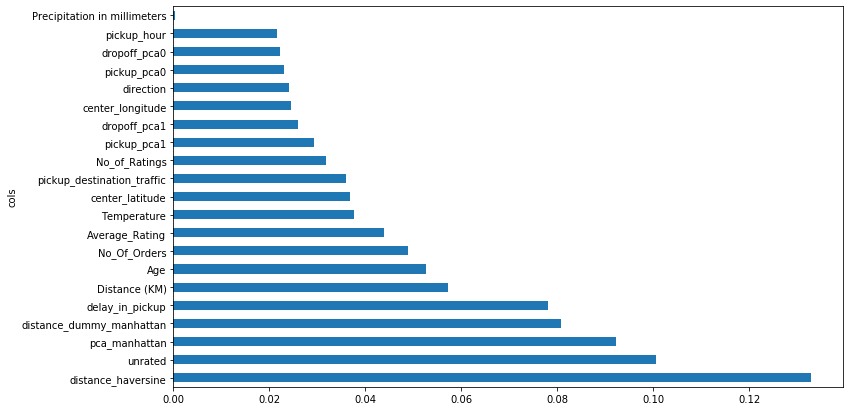

In [191]:
plot_fi(fi)

##### Light GBM

In [192]:
import lightgbm as lgb

In [193]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test)

In [194]:
gbm = lgb.train(params,
                d_train,
                num_boost_round=200,
                valid_sets=d_valid,
                early_stopping_rounds=10)


[1]	valid_0's l1: 0.670056	valid_0's l2: 1.35217
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 0.655056	valid_0's l2: 1.30889
[3]	valid_0's l1: 0.640921	valid_0's l2: 1.27003
[4]	valid_0's l1: 0.627713	valid_0's l2: 1.23324
[5]	valid_0's l1: 0.61575	valid_0's l2: 1.20147
[6]	valid_0's l1: 0.604396	valid_0's l2: 1.17093
[7]	valid_0's l1: 0.594166	valid_0's l2: 1.14304
[8]	valid_0's l1: 0.58449	valid_0's l2: 1.11771
[9]	valid_0's l1: 0.576042	valid_0's l2: 1.09672
[10]	valid_0's l1: 0.568005	valid_0's l2: 1.07717
[11]	valid_0's l1: 0.560441	valid_0's l2: 1.05831
[12]	valid_0's l1: 0.553291	valid_0's l2: 1.04058
[13]	valid_0's l1: 0.547188	valid_0's l2: 1.02514
[14]	valid_0's l1: 0.541476	valid_0's l2: 1.01097
[15]	valid_0's l1: 0.536819	valid_0's l2: 0.999401
[16]	valid_0's l1: 0.532559	valid_0's l2: 0.988205
[17]	valid_0's l1: 0.528081	valid_0's l2: 0.977143
[18]	valid_0's l1: 0.524328	valid_0's l2: 0.967914
[19]	valid_0's l1: 0.520981	valid_0's l2: 0.9

In [195]:
df_sample_submission = pd.read_csv('data/SampleSubmission.csv')

In [196]:
create_submission(df_sample=df_sample_submission, df_test=df_test_1, model=gbm, name='lgbm11')

,Time from Pickup to Arrival
Order_No,
Order_No_19248,6.845906
Order_No_12736,7.485000
Order_No_768,7.584321
Order_No_15332,7.487247
Order_No_21373,7.521897
...,...
Order_No_3612,7.705336
Order_No_7657,7.052999
Order_No_1969,7.424328


#### FEATURE 2

In [197]:
df_2 = df.drop(disjoint_cols,axis=1)

In [198]:
df_2.columns

Index(['Distance (KM)', 'Precipitation in millimeters', 'Temperature',
       'Time from Pickup to Arrival', 'col_type', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings', 'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'pca_manhattan',
       'center_latitude', 'center_longitude', 'pickup_hour',
       'pickup_destination_traffic', 'delay_in_pickup', 'unrated'],
      dtype='object')

In [199]:
df_2 = df_2.drop(['Distance (KM)', 'Precipitation in millimeters','distance_dummy_manhattan',],axis=1)

In [200]:
df_2.columns

Index(['Temperature', 'Time from Pickup to Arrival', 'col_type',
       'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings', 'pickup_pca0',
       'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine',
       'direction', 'pca_manhattan', 'center_latitude', 'center_longitude',
       'pickup_hour', 'pickup_destination_traffic', 'delay_in_pickup',
       'unrated'],
      dtype='object')

In [201]:
df_test_2 = df_2[df_2['col_type'] == 'test']
df_test_2 = df_test_2.drop(['col_type','Time from Pickup to Arrival'],axis=1)

In [202]:
train_2 = df_2[df_2['col_type'] == 'train' ]

In [203]:
train_2 = train_2.drop('col_type',axis=1)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(
    train_2.drop(["Time from Pickup to Arrival"],axis=1), train_2['Time from Pickup to Arrival'], test_size=0.33, random_state=42)

##### RF

In [205]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.6203022268331233, 0.9261426834686308, 0.7321142481420562, 0.3874520013811933, 0.335191217247094]


In [206]:
fi = rf_feat_importance(m,X_train)

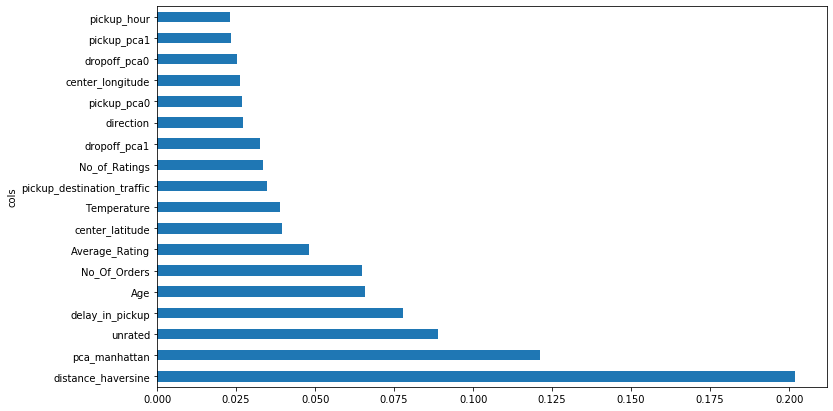

In [207]:
plot_fi(fi)

In [208]:
gbm = lgb.train(params,
                d_train,
                num_boost_round=200,
                valid_sets=d_valid,
                early_stopping_rounds=10)


[1]	valid_0's l1: 0.670056	valid_0's l2: 1.35217
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 0.655056	valid_0's l2: 1.30889
[3]	valid_0's l1: 0.640921	valid_0's l2: 1.27003
[4]	valid_0's l1: 0.627713	valid_0's l2: 1.23324
[5]	valid_0's l1: 0.61575	valid_0's l2: 1.20147
[6]	valid_0's l1: 0.604396	valid_0's l2: 1.17093
[7]	valid_0's l1: 0.594166	valid_0's l2: 1.14304
[8]	valid_0's l1: 0.58449	valid_0's l2: 1.11771
[9]	valid_0's l1: 0.576042	valid_0's l2: 1.09672
[10]	valid_0's l1: 0.568005	valid_0's l2: 1.07717
[11]	valid_0's l1: 0.560441	valid_0's l2: 1.05831
[12]	valid_0's l1: 0.553291	valid_0's l2: 1.04058
[13]	valid_0's l1: 0.547188	valid_0's l2: 1.02514
[14]	valid_0's l1: 0.541476	valid_0's l2: 1.01097
[15]	valid_0's l1: 0.536819	valid_0's l2: 0.999401
[16]	valid_0's l1: 0.532559	valid_0's l2: 0.988205
[17]	valid_0's l1: 0.528081	valid_0's l2: 0.977143
[18]	valid_0's l1: 0.524328	valid_0's l2: 0.967914
[19]	valid_0's l1: 0.520981	valid_0's l2: 0.9

In [209]:
create_submission(df_sample=df_sample_submission, df_test=df_test_2, model=gbm, name='lgbm12')

,Time from Pickup to Arrival
Order_No,
Order_No_19248,6.369844
Order_No_12736,6.236443
Order_No_768,5.971967
Order_No_15332,6.287386
Order_No_21373,6.287386
...,...
Order_No_3612,6.554270
Order_No_7657,6.504560
Order_No_1969,6.444369


#### FEATURES 3

In [210]:
disjoint_cols = ['Rider Id','User Id','Vehicle Type', 'Pickup Lat', 'Pickup Long',
                 'Destination Lat', 'Destination Long','Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)','Personal or Business','Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type','orders','dropoff_longitude',
       'dropoff_latitude','Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Order No','Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Placement - Day of Month','pickup_longitude', 'pickup_latitude','geometry']

In [211]:
cols_to_select = ['Distance (KM)','Age','delay_in_pickup','unrated','Average_Rating',
                  'Pickup Long','Pickup Lat','Destination Lat', 'Destination Long','Temperature',
                 'pickup_hour', 'pickup_destination_traffic','Pickup - Weekday (Mo = 1)','Pickup - Day of Month',"Time from Pickup to Arrival"]

In [212]:
df = df[cols_to_select]

In [213]:
df['Pickup - Day of Month'] = df['Pickup - Day of Month'].apply(month)

In [214]:
df.dtypes

Distance (KM)                    int64
Age                              int64
delay_in_pickup                float64
unrated                          int64
Average_Rating                 float64
Pickup Long                    float64
Pickup Lat                     float64
Destination Lat                float64
Destination Long               float64
Temperature                    float64
pickup_hour                      int64
pickup_destination_traffic       int64
Pickup - Weekday (Mo = 1)        int64
Pickup - Day of Month           object
Time from Pickup to Arrival    float64
dtype: object

In [215]:
cat_cols = ["pickup_hour","Pickup - Weekday (Mo = 1)","Pickup - Day of Month"]

In [216]:
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype('category'))

In [217]:
df.dtypes

Distance (KM)                     int64
Age                               int64
delay_in_pickup                 float64
unrated                           int64
Average_Rating                  float64
Pickup Long                     float64
Pickup Lat                      float64
Destination Lat                 float64
Destination Long                float64
Temperature                     float64
pickup_hour                    category
pickup_destination_traffic        int64
Pickup - Weekday (Mo = 1)      category
Pickup - Day of Month          category
Time from Pickup to Arrival     float64
dtype: object

In [218]:
import os
os.makedirs('tmp', exist_ok=True)
df.reset_index().to_feather('tmp/df_base')

In [251]:
df = pd.read_feather('tmp/df_base')

In [252]:
df["Time from Pickup to Arrival"] = np.exp(df["Time from Pickup to Arrival"])

In [253]:
df = pd.get_dummies(df, columns=['Pickup - Day of Month'])

In [254]:
df = df.drop("index",axis=1)

In [255]:
df_test = df[df['Time from Pickup to Arrival'].isnull()]

In [256]:
df = df[df["Time from Pickup to Arrival"] >= 120]

In [257]:
df.head()

,Distance (KM),Age,delay_in_pickup,unrated,Average_Rating,Pickup Long,Pickup Lat,Destination Lat,Destination Long,Temperature,pickup_hour,pickup_destination_traffic,Pickup - Weekday (Mo = 1),Time from Pickup to Arrival,Pickup - Day of Month_beg_month,Pickup - Day of Month_endmonth
1,4,771,162.0,967,14.1,36.796911,-1.274173,-1.265971,36.766806,21.800000,12,1,2,729.0,1,0
2,16,941,158.0,3698,14.1,36.828195,-1.300921,-1.388201,36.769945,23.255689,10,108,4,1923.0,0,1
3,15,1317,7.0,2166,14.3,36.828195,-1.300921,-1.388201,36.769945,18.300000,10,108,1,1392.0,0,1
4,16,1884,1415.0,2683,14.2,36.828195,-1.300921,-1.388201,36.769945,27.800000,14,108,4,1416.0,1,0
7,15,1120,227.0,3751,14.1,36.828195,-1.300921,-1.388201,36.769945,25.700000,10,108,6,1962.0,0,1


In [258]:
df_train = df[df['Time from Pickup to Arrival'].notnull()]
df_train.shape,df_test.shape

((20379, 16), (7068, 16))

In [259]:
from sklearn.linear_model import HuberRegressor,SGDRegressor,ElasticNet, Ridge,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold,cross_val_score

In [260]:
def rmse(y_true,y_preds,extras=None):
    return np.sqrt(mean_squared_error(y_true,y_preds))

def rmsle_cv(model,train,y_train,n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(np.mean(rmse))

def benchmark_model(train_x,train_y):
    for Model in [RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,XGBRegressor,LGBMRegressor, ElasticNet, LinearRegression,HuberRegressor]:
        model = Model()
        model_name = model.__class__.__name__
        err = rmsle_cv(model,train_x,train_y)
        print(f"{model_name} :  cross val loss => {err}")

In [261]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(["Time from Pickup to Arrival"],axis=1), df_train['Time from Pickup to Arrival'], test_size=0.30, random_state=42)

In [262]:
benchmark_model(train_x=X_train,train_y=y_train)

/Users/socrates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/socrates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/socrates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/socrates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/socrates/anaconda3/lib/py

RandomForestRegressor :  cross val loss => 790.5076776196693


/Users/socrates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/socrates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/socrates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/socrates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/socrates/anaconda3/lib/py

ExtraTreesRegressor :  cross val loss => 791.5702158060127
GradientBoostingRegressor :  cross val loss => 736.7881505526966
[05:11:31] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/socrates/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/socrates/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:11:32] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/socrates/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:11:33] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/socrates/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:11:34] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/socrates/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:11:35] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor :  cross val loss => 735.1829911643284
LGBMRegressor :  cross val loss => 728.7031276517512
ElasticNet :  cross val loss => 758.5688691775658
LinearRegression :  cross val loss => 757.1053900021659
HuberRegressor :  cross val loss => 781.1608043016738


In [263]:
def print_score(m):
    res = [
        rmse(m.predict(X_train), y_train),
        rmse(m.predict(X_test), y_test),
        m.score(X_train, y_train),
        m.score(X_test, y_test),
    ]
    if hasattr(m, "oob_score_"):
        res.append(m.oob_score_)
    print(res)

In [264]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[448.54464559738545, 757.4185587107744, 0.7748759323716774, 0.4042035117775056, 0.36405715097039126]


In [265]:
fi = rf_feat_importance(m,X_train)

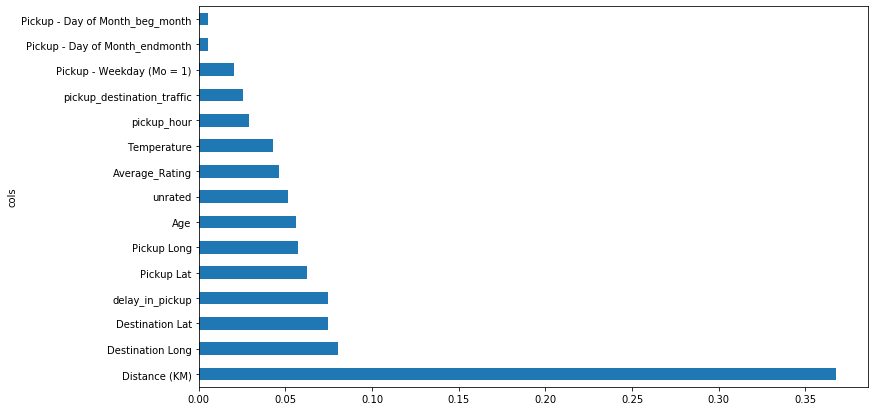

In [266]:
plot_fi(fi)

In [267]:
import lightgbm as lgb
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test)

In [268]:
gbm = lgb.train(params,
                d_train,
                num_boost_round=200,
                valid_sets=d_valid,
                early_stopping_rounds=6)


/Users/socrates/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 725.812	valid_0's l2: 929920
Training until validation scores don't improve for 6 rounds.
[2]	valid_0's l1: 711.141	valid_0's l2: 899575
[3]	valid_0's l1: 697.613	valid_0's l2: 872104
[4]	valid_0's l1: 684.703	valid_0's l2: 846570
[5]	valid_0's l1: 672.993	valid_0's l2: 823908
[6]	valid_0's l1: 661.855	valid_0's l2: 802761
[7]	valid_0's l1: 651.613	valid_0's l2: 783869
[8]	valid_0's l1: 642.161	valid_0's l2: 766730
[9]	valid_0's l1: 635.493	valid_0's l2: 755229
[10]	valid_0's l1: 626.952	valid_0's l2: 740261
[11]	valid_0's l1: 619.354	valid_0's l2: 726997
[12]	valid_0's l1: 612.32	valid_0's l2: 715124
[13]	valid_0's l1: 605.808	valid_0's l2: 704203
[14]	valid_0's l1: 599.718	valid_0's l2: 694116
[15]	valid_0's l1: 594.29	valid_0's l2: 684978
[16]	valid_0's l1: 588.947	valid_0's l2: 676033
[17]	valid_0's l1: 584.133	valid_0's l2: 668260
[18]	valid_0's l1: 579.69	valid_0's l2: 661136
[19]	valid_0's l1: 576.527	valid_0's l2: 656144
[20]	valid_0's l1: 572.714	valid_0's l2

In [270]:
create_submission(df_sample=df_sample_submission, df_test=df_test, model=gbm, name='lgbm-base')

,Time from Pickup to Arrival
Order_No,
Order_No_19248,1667.975180
Order_No_12736,1853.681218
Order_No_768,1769.542217
Order_No_15332,1826.710553
Order_No_21373,1834.559368
...,...
Order_No_3612,2456.460962
Order_No_7657,1838.096636
Order_No_1969,1839.288129


#### FEATURE 5

In [271]:
df = pd.read_feather('tmp/df_base')

In [ ]:
df